having read around how modern implementations of neural networks are done, I am going to try to add a few improvements to my class, namely:
- each step should only use a minibatch of 128 samples of the train data, not the whole dataset
- optional "dropout" to prevent overfitting, where randomly during training we have neurons zero-out with 20% probability
- do a train/validation 80/20 split, and do early stopping based on validation loss


In [4]:
seed = 136194553992213785217382377961235308297

In [23]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split


# 0 Set Up

In [6]:
train_df = pd.read_csv("/Users/wilhelmlannin/Documents/Python Stuff/MNIST_stuff/MNIST_CSV/mnist_train.csv",header=None)
train_df

# each row is a training case
# 0th column tells us the label for the case in that row
# rest of the columns tell us the pixel vals (reading left to right from top left)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 1 Improved Nnet Class

In [ ]:
# see my rough code notebook for justifications/derivations for the code used in the class below

# and see the attached pdfs for mathematical derivations of the gradients of each parameter

# and see the Nnet_class.ipynb file for the state of this class before I made these improvements

In [11]:
rng = np.random.default_rng(seed)
rng.random((3,5))

array([[0.32658274, 0.2497092 , 0.15885385, 0.19883791, 0.38386115],
       [0.14791713, 0.35724903, 0.92428994, 0.84056598, 0.40132719],
       [0.02834348, 0.36737094, 0.63633423, 0.9161938 , 0.32484364]])

In [16]:
test_mask = (rng.random(784) > 0.2).astype(np.float32)
print(test_mask.shape)
test_mask


(784,)


array([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1.

In [14]:
train_arr_01 = np.array(train_df.iloc[:,1:]) / 255

In [22]:
k=1
pre_masking = train_arr_01[k]
test_masked = np.multiply(pre_masking,test_mask)
test_masked
print(np.nonzero(pre_masking)[0].shape)
print(np.nonzero(test_masked)[0].shape)
# this masking has worked

(176,)
(148,)


In [26]:
ls = list(range(5))
rng.shuffle(ls)
ls

[1, 0, 4, 3, 2]

In [33]:
ls = list(range(6))
ls[:math.ceil(len(ls)*0.2)]

[0, 1]

In [29]:
len(train_df)

60000

In [111]:
class Nnet_improved:
    def __init__(self,train_df,initialization='He',nu=0.01,dropouts=[0.1,0.3,0.3,0],batch_size=128,random_seed=seed):
        #train_df: dataframe of mnist training cases 
        #initialization: method for weight initialisation. options are 'Xavier','Glorot','He'
        #nu: learning rate, deafult 0.01
        #dropouts: during training, zero-out a neuron in layer l with probability equal to dropouts[l]
        #batch_size: each gradient descent step will be derived using this many samples
        #random_seed: number that sets the randomness of ranom number generator for replicability

        self.train_df = train_df
        #set seed for random number generation
        self.rng = np.random.default_rng(seed)

        # split into train and validation
        # self.training_df, self.valid_df = train_test_split(train_df, test_size=0.2, random_state=random_seed, shuffle=True)

        # select top 20% as validation data and use rest as train data
        all_k = list(range(len(train_df)))
        self.rng.shuffle(all_k)
        valid_k = all_k[:math.ceil(len(train_df) * 0.2)]
        training_k = list(set(all_k) - set(valid_k))
        self.valid_df = train_df[train_df.index.isin(valid_k)].reset_index().drop(['index'],axis=1)
        self.training_df = train_df[train_df.index.isin(training_k)].reset_index().drop(['index'],axis=1)

        # map pixel values between 0 and 1
        self.train_arr_01 = np.array(self.training_df.iloc[:,1:]) / 255
        # and for validation
        self.valid_arr_01 = np.array(self.valid_df.iloc[:,1:]) / 255

        # true labels for each image
        self.t = np.array(self.training_df[0])
        #number of training images
        self.K = len(self.t)

        #number of neurons in each layer
        self.L = {0:784, 1:128, 2:64, 3:10}
        #bias vals initialised at 0
        self.b = {1:0, 2:0, 3:0}
        # weight matrices (randomly initialised using given initialization)
        if initialization in ['Xavier','Glorot']:
            var_scale = 1
        elif initialization=='He':
            var_scale = 2
        else:
            var_scale = 1
        
        self.W = {1:self.rng.normal(loc=0,scale=(var_scale/self.L[0])**0.5,size=[self.L[0],self.L[1]]),
            2:self.rng.normal(loc=0,scale=(var_scale/self.L[1])**0.5,size=[self.L[1],self.L[2]]),
            3:self.rng.normal(loc=0,scale=(var_scale/self.L[2])**0.5,size=[self.L[2],self.L[3]])}
        
        #exponential e^ function
        self.allexp = np.vectorize(math.exp)
        #ReLU activation function
        self.f = np.vectorize(lambda x: max([0,x]),otypes=[float])

        #learning rate parameter nu for gradient steps
        self.nu = nu
        #other parameters
        self.dropouts = dropouts
        self.batch_size = batch_size

        #training related data
        self.wsums = {l:{} for l in self.L.keys()}
        self.phat_all_k = []  # filled later
        self.g_b = self.b.copy()
        self.g_W = self.W.copy()
        self.gradient_steps_taken = 0
        self.epochs = 0

        

    def view_train_image_k(self,k):
        #silly way that I define the pixels at the start and end of each row
        bound=1
        bounds_list = []
        while bound < 784:
            bound_l = bound
            bound += 28
            bound_u = bound
            bounds_list += [(bound_l,bound_u)]
        #now use these bounds to show the train image
        print("label:",self.training_df.iloc[k,0])
        img = np.array([list(self.training_df.iloc[k,x[0]:x[1]]) for x in bounds_list])
        plt.imshow(img, cmap='gray')
        plt.show()

    def generate_phat_k(self,k):
        vec = self.train_arr_01[k]
        p3 = self.f(self.b[3] + ( self.f(self.b[2] + ( self.f(self.b[1] + ( vec @ self.W[1] )) @ self.W[2])) @ self.W[3]))
        expvec = self.allexp(p3)
        phat = expvec/sum(expvec)
        return phat

    
    def predict_k(self,k):
        vec = self.train_arr_01[k]
        p3 = self.f(self.b[3] + ( self.f(self.b[2] + ( self.f(self.b[1] + ( vec @ self.W[1] )) @ self.W[2])) @ self.W[3]))
        expvec = self.allexp(p3)
        phat = expvec/sum(expvec)
        #return the first label that has the highest softmax probability in phat
        return [idx for idx,val in enumerate(phat) if val >= max(phat)][0]
    
    def validation_generate_phat_k(self,k):
        vec = self.valid_arr_01[k]
        p3 = self.f(self.b[3] + ( self.f(self.b[2] + ( self.f(self.b[1] + ( vec @ self.W[1] )) @ self.W[2])) @ self.W[3]))
        expvec = self.allexp(p3)
        phat = expvec/sum(expvec)
        return phat
    
    def validation_loss(self):
        # calculate loss on the validation dataset
        # true labels for each validation image
        vt = np.array(self.valid_df[0])
        #number of training images
        vK = len(vt)
        #cross entropy loss
        return (-1/vK)*sum([math.log(self.validation_generate_phat_k(idx)[t_val]) for idx,t_val in enumerate(vt)])
    
    def train_loss(self):
        # calculate loss on the train ing dataset
        # true labels for each image
        t = np.array(self.training_df[0])
        #number of training images
        K = len(t)
        #cross entropy loss
        return (-1/K)*sum([math.log(self.generate_phat_k(idx)[t_val]) for idx,t_val in enumerate(t)])
                    
    def accuracy(self):
        vec_predict = np.vectorize(self.predict_k)
        pred_labels1 = vec_predict(np.array(range(len(self.t))))
        # TOTAL ACCURACY (percent of cases that the model predicted correctly)
        true_val_checklist = [pred_labels1[k]==true_val for k,true_val in enumerate(self.t)]
        total_accuracy = sum(true_val_checklist)/len(true_val_checklist)
        return total_accuracy
        
    def all_performance(self):
        vec_predict = np.vectorize(self.predict_k)
        pred_labels1 = vec_predict(np.array(range(len(self.t))))

        # TOTAL ACCURACY (percent of cases that the model predicted correctly)
        true_val_checklist = [pred_labels1[k]==true_val for k,true_val in enumerate(self.t)]
        total_accuracy = sum(true_val_checklist)/len(true_val_checklist)
        print(total_accuracy)
        print("total accuracy =", round(100*total_accuracy,2),"%")

        # digit accuracy is the percent of training cases containing digit n that the model predicted correctly
        digit_accuracy = {}
        for digit in range(10):
            train_cases_containing_digit = [k for k,true_val in enumerate(self.t) if true_val==digit]
            # now calculate how many of these cases we predicted correctly
            checklist = [pred_labels1[k]==digit for k in train_cases_containing_digit]
            digit_accuracy[digit] = sum(checklist)/len(checklist)
        print("digit accuracy:")
        print(digit_accuracy)

        # digit recall should tell us the percent of cases the model predicted as that digit that were actually that digit
        digit_recall = {}
        for digit in range(10):
            cases_we_predicted_digit = [k for k,true_val in enumerate(pred_labels1) if true_val==digit]
            # now calculate how many of these cases actually contained this digit correctly
            checklist = [self.t[k]==digit for k in cases_we_predicted_digit]
            digit_recall[digit] = sum(checklist)/len(checklist) if len(checklist) != 0 else None
        print("digit_recall:")
        print(digit_recall)

    def calc_wsums_and_phat_all_k(self,masks,k_list):
        # we need every single weight sum for every single k, so create a data structure that allows us to store these conveniently


        self.wsums[1] = {k:self.b[1] + (np.multiply(masks[0],self.train_arr_01[k]) @ self.W[1]) for k in k_list}
        # now we need to define the second layer weight sums using wsums[1]
        self.wsums[2] = {k:self.b[2] + np.multiply(masks[1],self.f(self.wsums[1][k])) @ self.W[2] for k in k_list}
        # and define the 3rd layer weight sums using the second weight sums we just calculated
        self.wsums[3] = {k:self.b[3] + np.multiply(masks[2],self.f(self.wsums[2][k])) @ self.W[3] for k in k_list}
        #this way, we get all the weight sums we need and only have to do each matrix multiplication once! work samrter not harder?

        # now we need to arrive at phat for each training case k from the layer 3 weightsums in wsums[3]
        expvec_all_k = {k:self.allexp(self.f(self.wsums[3][k])) for k in k_list}
        self.phat_all_k = {k:expvec_all_k[k]/sum(expvec_all_k[k]) for k in k_list}

        #extra calcs done for all k, not k_list
        self.i3W3_all_k_all_z_fast = {k:[
            np.array(self.W[3][:,z]) if (self.wsums[3][k][z] > 0) else np.zeros(self.L[2]) for z in range(self.L[3])
                ]
                  for k in k_list       
        }
                
        
        self.i3thensum_all_k_all_z_3 = {
                k:[
                    np.sum(np.multiply(self.W[2][:,np.nonzero(self.wsums[2][k] > 0)[0]],
                                #this is "repeated" we defined earlier
                                np.repeat([self.W[3][np.nonzero(self.wsums[2][k] > 0)[0],z]],repeats=self.L[1],axis=0)),axis=1,initial=0)
                                    if (self.wsums[3][k][z] > 0) else np.zeros(self.L[1]) for z in range(self.L[3])
                ] for k in k_list
            }


    def calc_bias_gradients(self,masks,k_list):
        #note that masks are not needed for the bias gradient calculations, so argument is unused!

        # biases
        self.g_b[3] = -sum([(self.wsums[3][k][self.t[k]] > 0) - sum([self.phat_all_k[k][z] for z in range(self.L[3]) if self.wsums[3][k][z] > 0]) for k in k_list]) / len(k_list)


        self.g_b[2] = -sum([(sum([self.W[3][i][self.t[k]] for i in range(self.L[2]) if self.wsums[2][k][i] > 0]) if self.wsums[3][k][self.t[k]] > 0 else 0) \
        - sum([self.phat_all_k[k][z]*sum([self.W[3][i][z] for i in range(self.L[2]) if self.wsums[2][k][i] > 0]) for z in range(self.L[3]) if self.wsums[3][k][z] > 0]) for k in k_list]) / len(k_list)

        self.g_b[1] = -sum(
            [
                (
                    np.sum(
                    np.multiply(self.W[3][np.nonzero(self.wsums[2][k][:] > 0),self.t[k]] , np.sum(self.W[2][np.nonzero(self.wsums[1][k][:] > 0)][:,np.nonzero(self.wsums[2][k][:] > 0)],initial=0,axis=0))
                        ) if self.wsums[3][k][self.t[k]] > 0 else 0) \
        - sum(
            [
                self.phat_all_k[k][z]*(np.sum(
                    np.multiply(self.W[3][np.nonzero(self.wsums[2][k][:] > 0),z] , np.sum(self.W[2][np.nonzero(self.wsums[1][k][:] > 0)][:,np.nonzero(self.wsums[2][k][:] > 0)],initial=0,axis=0))
                        ) if self.wsums[3][k][z] > 0 else 0) for z in range(self.L[3]) if self.wsums[3][k][z] > 0]
                        ) for k in k_list]) / len(k_list)
    
    def calc_weight_gradients(self,masks,k_list):

        self.g_W[3] = np.transpose(-np.sum(np.array([np.multiply(np.array([np.repeat([( (b==self.t[k]) - self.phat_all_k[k][b] )],repeats=self.L[2]) for b in range(self.L[3])]),np.transpose(np.array(self.wsums[3][k] > 0,ndmin=2)) @ np.array(self.f(self.wsums[2][k]),ndmin=2))
                                    for k in k_list]),axis=0) / len(k_list))
        
        # so, here is the final code I'll use for layer 2 weights
        

        self.g_W[2] = -sum([np.multiply(
            #start np.multiply with the transpose of new_dotted
            np.transpose(np.transpose(np.array(self.wsums[2][k] > 0,ndmin=2)) @ np.array(self.f(self.wsums[1][k]),ndmin=2)),
                    #bracketsterm_repeated is defined as the right-part of this np.multiply
                    np.repeat([self.i3W3_all_k_all_z_fast[k][self.t[k]] - np.sum(np.array([self.phat_all_k[k][z] * self.i3W3_all_k_all_z_fast[k][z] for z in range(self.L[3])]),axis=0)],repeats=self.L[1],axis=0))
                    for k in k_list]) / len(k_list)
        
        # so in totality here is g_W[1]
        

        self.g_W[1] = -sum([np.multiply(
            #start np.multiply with the same idea as new_dotted in the g_W[2] case, but with layers 2 and 1 swapped for 1 and 0 (resp.)
            # MASK USED HERE since we actually access a neuron value here, not just a weightsum, so we zero neurons mask tells us to!
            np.transpose(np.transpose(np.array(self.wsums[1][k] > 0,ndmin=2)) @ np.array(np.multiply(masks[0],self.train_arr_01[k]),ndmin=2)),
                    #then this second part of np.multiply is similar to the g_W[2] case, using i3thensum_all_k_all_z_3 in place of i3W3_all_k_all_z (and repeat L[0] times)
                    np.repeat([self.i3thensum_all_k_all_z_3[k][self.t[k]] - np.sum(np.array([self.phat_all_k[k][z] * self.i3thensum_all_k_all_z_3[k][z] for z in range(self.L[3])]),axis=0)],repeats=self.L[0],axis=0))
                    for k in k_list]) / len(k_list)
        
    def take_1epoch_gradient_step(self):
        # now divide entire train dataset into batches of batch_size size
        batch_dict = {}
        batch_id = 0
        total_samples = 0
        remaining_k = list(range(len(self.t)))
        # shuffle the list so each epoch is batched differently
        self.rng.shuffle(remaining_k)
        while total_samples < self.K:
            # take a sample of size self.batch_size from all remaining k
            batch_dict[batch_id] = self.rng.choice(remaining_k, self.batch_size, replace=False)
            # remove these from the remaining k
            remaining_k = list(set(remaining_k) - set(batch_dict[batch_id]))
            # and add to total samples and batch_id to reflect this new batch
            total_samples += self.batch_size
            batch_id += 1
            # repeat until we've divided the entire dataset
        
        # now for each batch, perform a step
        for batch_id,k_list in batch_dict.items():
            # dropout mask for each layer of the network, that will randomly zero-out neurons during training
            masks = {}
            for layer_id in self.L:
                #dropout for this batch with probability p, and re-scale using (1-p)
                p = self.dropouts[layer_id]
                masks[layer_id] = (self.rng.random(self.L[layer_id]) > p) / (1 - p)

            #pre calcs - would be quicker if first method used k_list !
            self.calc_wsums_and_phat_all_k(masks,k_list)
            self.calc_bias_gradients(masks,k_list)
            self.calc_weight_gradients(masks,k_list)

            # now we have all the gradients calculated for this step, take the step
            for l in [1,2,3]:
                #gradient step for bias and weioghts corresponding to layer l
                self.b[l] -= self.nu*self.g_b[l]
                self.W[l] -= self.nu*self.g_W[l]

            #increase number of steps taken
            self.gradient_steps_taken += 1

        #increase number of epochs
        self.epochs += 1
        
        

    def train_network_v2(self,eps=0.000001,max_wait_epochs=5,max_epochs=150):
        #function to train the network via many calls to self.take_1epoch_gradient_step

        # validation loss pre step
        pre_vloss = self.validation_loss()

        #initialise epochs_waited
        epochs_waited=0

        while self.epochs < max_epochs:

            # step
            self.take_1epoch_gradient_step()

            #vloss after the step
            post_vloss = self.validation_loss()
            post_tloss = self.train_loss()
            print(f"After {self.epochs} epochs, train loss:",post_tloss,", valid loss:",post_vloss)

            # also print accuracy every 5 epochs
            if self.epochs % 5 == 0:
                print(f"Train Accuracy: {round(self.accuracy(),3)} %")

            # if the vloss improved, continue
            if post_vloss < pre_vloss:
                pre_vloss = post_vloss
                #also reset epochs waited
                epochs_waited = 0
                continue
            else:
                pre_vloss = post_vloss
                #add to epochs waited
                epochs_waited += 1
                #if we have surpassed max steps waited we stop
                if epochs_waited > max_wait_epochs:
                    return





# 2 Train

In [114]:
Improvenet1 = Nnet_improved(train_df,initialization='He',nu=0.01,dropouts=[0,0,0,0],batch_size=128,random_seed=seed)


In [115]:

Improvenet1.train_network_v2()
#1 epoch took around 1m15s



After 1 epochs, train loss: 1.2385195101780757 , valid loss: 1.240228655663118
After 2 epochs, train loss: 0.7420300014663547 , valid loss: 0.7523659291612438
After 3 epochs, train loss: 0.39697654910720415 , valid loss: 0.3985487005064886
After 4 epochs, train loss: 0.34389680508662185 , valid loss: 0.3472790860752109
After 5 epochs, train loss: 0.31512393910111264 , valid loss: 0.31935404409166873
Train Accuracy: 0.911 %
After 6 epochs, train loss: 0.29549767298828905 , valid loss: 0.3000774588545823
After 7 epochs, train loss: 0.2786068703859967 , valid loss: 0.2841091099338159
After 8 epochs, train loss: 0.26670534887545333 , valid loss: 0.27316052551744147
After 9 epochs, train loss: 0.2561785463681064 , valid loss: 0.26379011753681714
After 10 epochs, train loss: 0.24603989777954305 , valid loss: 0.25514067047517003
Train Accuracy: 0.93 %
After 11 epochs, train loss: 0.23896796805693918 , valid loss: 0.24833934962201826
After 12 epochs, train loss: 0.22830713304112926 , valid los

KeyboardInterrupt: 

In [116]:
Improvenet1.all_performance()

0.9877916666666666
total accuracy = 98.78 %
digit accuracy:
{0: 0.9935010482180293, 1: 0.990909090909091, 2: 0.9922088860812802, 3: 0.9797119091093528, 4: 0.985501066098081, 5: 0.9884845693228926, 6: 0.9900592216582065, 7: 0.9866160607271275, 8: 0.9906143344709898, 9: 0.9802463891248938}
digit_recall:
{0: 0.9903866248693834, 1: 0.9929354898680052, 2: 0.9884623452905391, 3: 0.9915811088295687, 4: 0.9880290722530997, 5: 0.9862132352941176, 6: 0.9948990435706695, 7: 0.9895812462432378, 8: 0.9756302521008403, 9: 0.979206450244006}


# 3 Test Data

In [117]:
test_df = pd.read_csv("/Users/wilhelmlannin/Documents/Python Stuff/MNIST_stuff/MNIST_CSV/mnist_test.csv",header=None)
test_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
test_arr_01 = np.array(test_df.iloc[:,1:]) / 255

label: 0


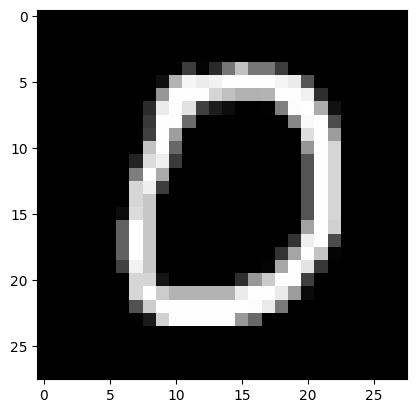

In [119]:
def view_kth_test_case(k):
    # view image
    #silly way that I define the pixels at the start and end of each row
    bound=1
    bounds_list = []
    while bound < 784:
        bound_l = bound
        bound += 28
        bound_u = bound
        bounds_list += [(bound_l,bound_u)]
    #now use these bounds to show the train image
    print("label:",test_df.iloc[k,0])
    img = np.array([list(test_df.iloc[k,x[0]:x[1]]) for x in bounds_list])
    plt.imshow(img, cmap='gray')
    plt.show()

view_kth_test_case(10)

In [120]:
# predict kth row of the test data

def predict_kth_test_case(k,Nnet_instance):
        vec = test_arr_01[k]
        p3 = Nnet_instance.f(Nnet_instance.b[3] + ( Nnet_instance.f(Nnet_instance.b[2] + ( Nnet_instance.f(Nnet_instance.b[1] + ( vec @ Nnet_instance.W[1] )) @ Nnet_instance.W[2])) @ Nnet_instance.W[3]))
        expvec = Nnet_instance.allexp(p3)
        phat = expvec/sum(expvec)
        #return the first label that has the highest softmax probability in phat
        return [idx for idx,val in enumerate(phat) if val >= max(phat)][0]


label: 1


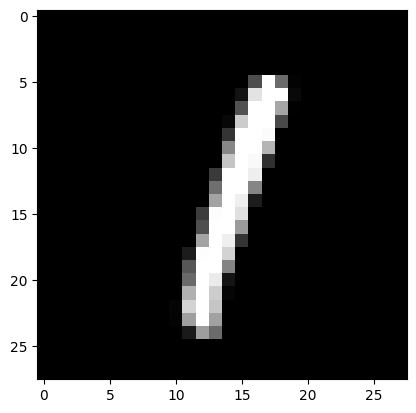

Improvenet1's prediction:
1


In [121]:
k=5
view_kth_test_case(k)
print("Improvenet1's prediction:")
print(predict_kth_test_case(k,Improvenet1))

In [ ]:
import copy
#make a copy of quicknet from 20250302
# Improvenet1_20250322 = copy.deepcopy(Improvenet1)

## test on own images

In [ ]:
# darya and I drew some of our own 28x28 pixel images to test the net on!

In [122]:
from PIL import Image

In [123]:

# Load the image

image = Image.open("drawnimg1.png").convert("L")  # Convert to grayscale

# Resize to 28x28
# image = image.resize((28, 28))

# Convert to NumPy array
array = np.array(image)

# Flatten the array into 784 elements
flattened_array = array.flatten()

# Print shape to verify
print(flattened_array.shape)  # Should print (784,)

# Display the first few pixel values
print(flattened_array[:10])

(784,)
[0 0 0 0 0 0 0 0 0 0]


In [124]:
def img_to_array(img_path):
    image = Image.open(img_path).convert("L")  # Convert to grayscale

    # Convert to NumPy array
    array = np.array(image)

    # Flatten the array into 784 elements
    return array.flatten()


In [125]:
flattened_array

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       181, 181, 181, 181, 181, 181, 181, 181, 181,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 181, 181,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       181,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

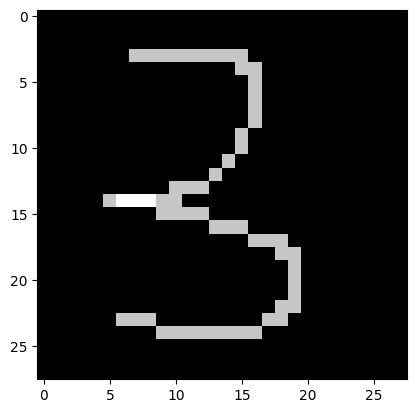

In [126]:
def view_image(pixel_array):
    # view image
    #silly way that I define the pixels at the start and end of each row
    bound=0
    bounds_list = []
    while bound < 783:
        bound_l = bound
        bound += 28
        bound_u = bound
        bounds_list += [(bound_l,bound_u)]
    img = np.array([list(pixel_array[x[0]:x[1]]) for x in bounds_list])
    plt.imshow(img, cmap='gray')
    plt.show()

view_image(flattened_array)

In [136]:
# predict
def predict_image(pixel_array,Nnet_instance):
        vec = pixel_array / 255
        p3 = Nnet_instance.f(Nnet_instance.b[3] + ( Nnet_instance.f(Nnet_instance.b[2] + ( Nnet_instance.f(Nnet_instance.b[1] + ( vec @ Nnet_instance.W[1] )) @ Nnet_instance.W[2])) @ Nnet_instance.W[3]))
        expvec = Nnet_instance.allexp(p3)
        phat = expvec/sum(expvec)
        #return the first label that has the highest softmax probability in phat
        return [idx for idx,val in enumerate(phat) if val >= max(phat)][0]


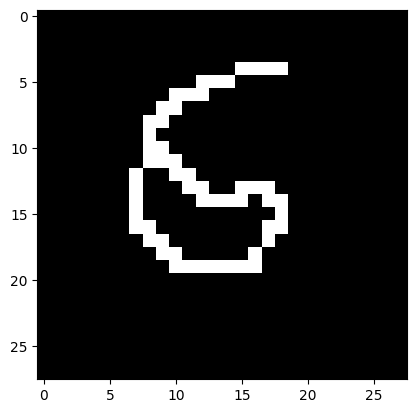

Improvenet1's prediction:
4


In [137]:
pixel_array = img_to_array("drawnimg6.png")
view_image(pixel_array)
print("Improvenet1's prediction:")
print(predict_image(pixel_array,Improvenet1))


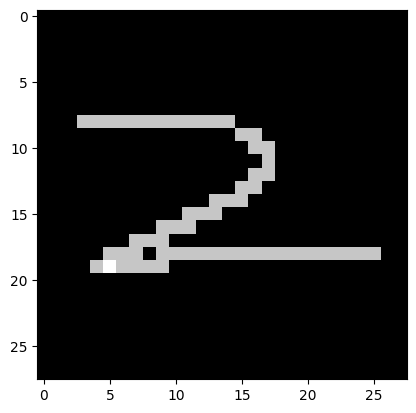

Improvenet1's prediction:
2


In [138]:
pixel_array = img_to_array("drawnimg22.png")
view_image(pixel_array)
print("Improvenet1's prediction:")
print(predict_image(pixel_array,Improvenet1))

#correct!


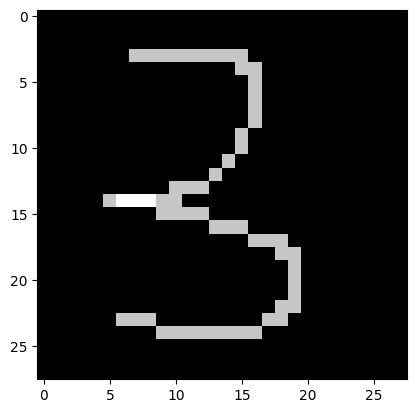

Improvenet1's prediction:
3



In [139]:
pixel_array = img_to_array("drawnimg1.png")
view_image(pixel_array)
print("Improvenet1's prediction:")
print(predict_image(pixel_array,Improvenet1))
print()

# it got this one wrong


## all test data performance

In [131]:
# equivalent of the vector t of true labels for the test set:
test_t = list(test_df.iloc[:,0])
len(test_t)

10000

In [132]:
# specific version of predict kth test case function
def inet_predict_kth_test_case(k):
        vec = test_arr_01[k]
        p3 = Improvenet1.f(Improvenet1.b[3] + ( Improvenet1.f(Improvenet1.b[2] + ( Improvenet1.f(Improvenet1.b[1] + ( vec @ Improvenet1.W[1] )) @ Improvenet1.W[2])) @ Improvenet1.W[3]))
        expvec = Improvenet1    .allexp(p3)
        phat = expvec/sum(expvec)
        #return the first label that has the highest softmax probability in phat
        return [idx for idx,val in enumerate(phat) if val >= max(phat)][0]

In [133]:
# rework the method used to check performance in my nnet class
def test_performance():
    vec_predict = np.vectorize(inet_predict_kth_test_case)
    pred_labels1 = vec_predict(np.array(range(len(test_t))))

    # TOTAL ACCURACY (percent of cases that the model predicted correctly)
    true_val_checklist = [pred_labels1[k]==true_val for k,true_val in enumerate(test_t)]
    total_accuracy = sum(true_val_checklist)/len(true_val_checklist)
    print(total_accuracy)
    print("total test-set accuracy =", round(100*total_accuracy,2),"%")

    # digit accuracy is the percent of training cases containing digit n that the model predicted correctly
    digit_accuracy = {}
    for digit in range(10):
        train_cases_containing_digit = [k for k,true_val in enumerate(test_t) if true_val==digit]
        # now calculate how many of these cases we predicted correctly
        checklist = [pred_labels1[k]==digit for k in train_cases_containing_digit]
        digit_accuracy[digit] = sum(checklist)/len(checklist)
    print("test-set digit accuracy:")
    print(digit_accuracy)

    # digit recall should tell us the percent of cases the model predicted as that digit that were actually that digit
    digit_recall = {}
    for digit in range(10):
        cases_we_predicted_digit = [k for k,true_val in enumerate(pred_labels1) if true_val==digit]
        # now calculate how many of these cases actually contained this digit correctly
        checklist = [test_t[k]==digit for k in cases_we_predicted_digit]
        digit_recall[digit] = sum(checklist)/len(checklist) if len(checklist) != 0 else None
    print("test-set digit recall:")
    print(digit_recall)


In [ ]:
test_performance()
# overall I am VERY happy to see how our neural net performs on the unseen test-set!



0.9714
total test-set accuracy = 97.14 %
test-set digit accuracy:
{0: 0.9857142857142858, 1: 0.9885462555066079, 2: 0.9718992248062015, 3: 0.9722772277227723, 4: 0.9643584521384929, 5: 0.9697309417040358, 6: 0.9728601252609603, 7: 0.9678988326848249, 8: 0.9671457905544147, 9: 0.9514370664023786}
test-set digit recall:
{0: 0.972809667673716, 1: 0.9894179894179894, 2: 0.9775828460038987, 3: 0.9665354330708661, 4: 0.9742798353909465, 5: 0.958980044345898, 6: 0.9789915966386554, 7: 0.9726295210166178, 8: 0.9563451776649746, 9: 0.9628886659979939}


## save parameters

In [1]:
import json
from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)



In [3]:
# # save quicknet weights and biases as json
# biases = Improvenet1.b

# print(biases)


# with open('Improvenet1_biases.json', 'w') as fp:
#     json.dump(biases, fp)


In [4]:
# weights = Improvenet1.W

# with open('Improvenet1_weights.json', 'w') as fp:
#     json.dump(weights, fp, cls=NumpyArrayEncoder)